### Introduction
This Notebook is the continuation of `arvato_data_cleaning.ipynb`, where I showed how the Arvato customer and demographic data will be cleaned. Here, we can use the `clean_data()` function we wrote in the last Notebook after importing it from our helper method file. 

After the data has been cleaned, we can use Principle Component Analysis as a means of dimensionality reduction before grouping our customers using KMeans clustering.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from arvato_helper_methods import clean_data

import pickle

### Load and clean the data

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

#open pickled list that contains missing values data for each column
with open ('to_save.txt', 'rb') as file:
    to_save = pickle.load(file)
    
#load in customer data
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [3]:
#clean demographics data
azdias_sub = clean_data(azdias, to_save)

#should have shape (623209, 88) to match our above processing steps
print(azdias_sub.shape)

(623209, 88)


### Feature scaling

scikit-learn's clustering methods require that we have no missing data. We took care of that in the pre-processing steps. However, we also need to scale our values so that one variable's variance doesn't affect how types customers get grouped together. Scikit-learn makes it easy to do that with the [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) package. This scales each feature to mean 0 and standard deviation 1.

In [72]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

#fit and transform the data in one step
#now we move from a dataframe to a numpy array
scaled = pd.DataFrame(scaler.fit_transform(azdias_sub), columns=azdias_sub.columns, index=azdias_sub.index)

In [73]:
#let's look at what the scaling did
scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,WOHNLAGE_0.0,WOHNLAGE_1.0,WOHNLAGE_2.0,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0
1,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,-0.206656,-0.32394,-0.002533,-0.249828,-0.383618,-0.698947,2.171272,-0.314560,-0.518556,-0.088756
2,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,-0.206656,-0.32394,-0.002533,-0.249828,2.606756,-0.698947,-0.460560,-0.314560,-0.518556,-0.088756
4,0.202107,-1.022678,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,-0.553670,1.044647,...,-0.206656,-0.32394,-0.002533,-0.249828,-0.383618,1.430724,-0.460560,-0.314560,-0.518556,-0.088756
5,-1.746291,0.977825,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.553670,1.044647,...,-0.206656,-0.32394,-0.002533,-0.249828,-0.383618,-0.698947,-0.460560,-0.314560,1.928432,-0.088756
6,-0.772092,0.977825,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.553670,-0.273496,...,-0.206656,-0.32394,-0.002533,-0.249828,-0.383618,-0.698947,-0.460560,3.179044,-0.518556,-0.088756


Since I didn't have any missing data (see the above step on only keeping rows without any missing data), I went ahead and scaled my data. Even when using only rows with no missing values, I still have 75% of my data left (before adding dummy variables or engineered features).

### Dimensionality Reduction

Now we can perform PCA on our scaled data to see if there are any variables that explain some amount of shared variance (meaning that they contribute nothing extra to our analysis). If this is the case, we can drop them and save compute resources.

In [74]:
# Apply PCA to the data.
pca = PCA()

#fit and transform the data here, create principal components
pcs = pca.fit_transform(scaled)

#print the explained variance ratio of the first five principal components
var_ratio = pca.explained_variance_ratio_
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

print(var_ratio[:5])

[ 0.13922643  0.10764592  0.07106963  0.04434399  0.03161276]


In [75]:
#find the index where we cross 90% variance explained
#the first [0] moves from array to list object, the second isolates the first index
idx_90 = np.where(cumulative_var > 0.90)[0][0]

#or 95% variance explained
idx_95 = np.where(cumulative_var > 0.95)[0][0]

In [78]:
print('If we wanted to retain 90% of the variance explained, we would need to keep {} PCs.'.format(idx_90+1))
print('If we wanted to retain 95% of the variance explained, we would need to keep {} PCs.'.format(idx_95+1))

If we wanted to retain 90% of the variance explained, we would need to keep 46 PCs.
If we wanted to retain 95% of the variance explained, we would need to keep 57 PCs.


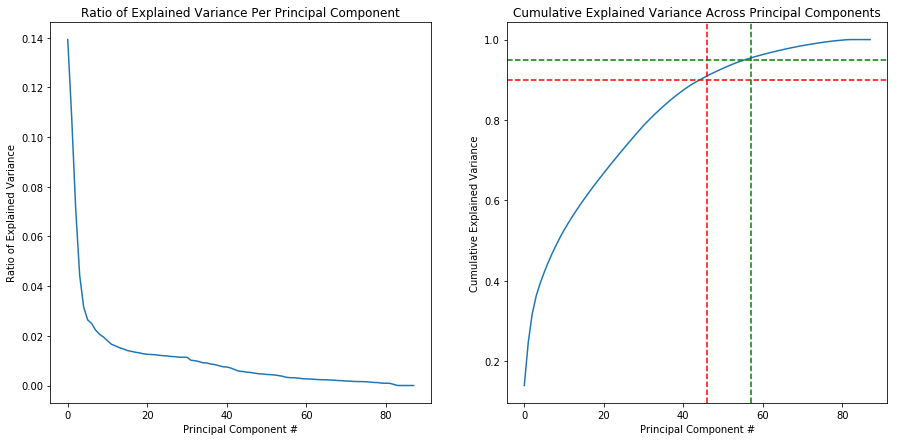

In [80]:
# Investigate the variance accounted for by each principal component.
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].plot(var_ratio)
ax[1].plot(cumulative_var)

ax[0].set_xlabel('Principal Component #')
ax[0].set_ylabel('Ratio of Explained Variance')
ax[0].set_title('Ratio of Explained Variance Per Principal Component')

ax[1].set_xlabel('Principal Component #')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].set_title('Cumulative Explained Variance Across Principal Components')

#show where the number of pcs crosses a certain level of cumulative variance
ax[1].axhline(y=0.90, linestyle='--', color='r')
ax[1].axvline(x=46, linestyle='--', color='r')

ax[1].axhline(y=0.95, linestyle='--', color='g')
ax[1].axvline(x=57, linestyle='--', color='g')

plt.show()

In [81]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=57)

#fit and transform the data here, create principal components
pcs = pca.fit_transform(scaled)

#print the explained variance ratio of the first five principal components
var_ratio = pca.explained_variance_ratio_
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

In [82]:
print(pcs.shape)

(623209, 57)


The Principal Components do not explain as much variance as we would like early on. It would be ideal if the first PC explained greater than 50% of the variance, but we don't reach that level until we keep around 30 components. Still, we can reduce the data set by almost half while still maintaining 95% of the explained variance. I could have chosen to keep 90% of the variance with 12 less features (as compared to the 95% case), but 12 extra features will not slow down our performance by that much. So it is better to keep the extra 5% of variance.

In [83]:
#input an index for the principal components and the pca.components_ list
#output a list of sorted weights for the pc at index idx
def pca_weights_to_features(idx, weights):
    
    #extract number of pcs, and columns from original data set
    pcs, cols = weights.shape
    
    #make sure that the index is in the number of pcs
    if idx not in range(pcs):
        raise ValueError('Please enter an index from 0 to {}'.format(pcs))
    
    #extract the weights for the pc at index idx to analyze
    pc_weights = weights[idx]
    
    #sort the feature weights
    feature_weights = sorted(pc_weights)
    
    
    #now create feature weight indices corresponding to column names in original data
    feature_idx = []
    for weight in feature_weights:
        weight_idx = np.where(pc_weights==weight)[0][0]
        feature_idx.append(weight_idx)
        
    #round the feature weights to 4 decimal places for readability
    feature_weights = np.round(feature_weights, 4)
    
    #return sorted weights and indices
    return feature_weights, feature_idx

In [84]:
#report the first and last 3 weights for PC and index i
#do the same thing for the corresponding feature names
def report_weights_and_cols(weights, indices, idx):
    
    #get first and last 3 columns which correspond the most highly with PC1
    first_cols = list(columns[indices[:3]])
    last_cols = list(columns[indices[-3:]])

    #print the first and last 3 weights and indices for pc1
    print('The first 3 weights for PC{} are: {}'.format(idx+1, weights[:3]))
    print('These correspond to the columns {}'.format(first_cols), '\n')

    print('The last 3 weights for PC{} are: {}'.format(idx+1, weights[-3:]))
    print('These correspond to the columns {}'.format(last_cols), '\n')

In [85]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights1, indices1 = pca_weights_to_features(0, pca.components_)

report_weights_and_cols(weights1, indices1, 0)

The first 3 weights for PC1 are: [-0.2219 -0.2157 -0.2081]
These correspond to the columns ['MOBI_REGIO', 'FINANZ_MINIMALIST', 'KBA05_ANTG1'] 

The last 3 weights for PC1 are: [ 0.1884  0.1964  0.2026]
These correspond to the columns ['HH_EINKOMMEN_SCORE', 'PLZ8_ANTG4', 'PLZ8_ANTG3'] 



In [86]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights2, indices2 = pca_weights_to_features(1, pca.components_)

report_weights_and_cols(weights2, indices2, 1)

The first 3 weights for PC2 are: [-0.2372 -0.2346 -0.2188]
These correspond to the columns ['SEMIO_REL', 'PRAEGENDE_JUGENDJAHRE_decade', 'SEMIO_PFLICHT'] 

The last 3 weights for PC2 are: [ 0.2069  0.2121  0.2385]
These correspond to the columns ['SEMIO_ERL', 'FINANZ_VORSORGER', 'ALTERSKATEGORIE_GROB'] 



In [87]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights3, indices3 = pca_weights_to_features(2, pca.components_)

report_weights_and_cols(weights3, indices3, 2)

The first 3 weights for PC3 are: [-0.3702 -0.3401 -0.3123]
These correspond to the columns ['ANREDE_KZ', 'SEMIO_KAEM', 'SEMIO_DOM'] 

The last 3 weights for PC3 are: [ 0.2626  0.2686  0.3487]
These correspond to the columns ['SEMIO_FAM', 'SEMIO_SOZ', 'SEMIO_VERT'] 



### Interpreting our Principle Components
I looked up what the corresponding columns for each Principal Component were:
- PC1: <br>
    positive: movement patterns, financial typology, num 1-2 family houses in microcell

    negative: num 10+ family houses in region, num 6-10 family houses in region, social status (as income earners)


- PC2: <br>
    positive: personality typology, decade from, financial typology (how they spend or invest money)

    negative: financial typology (how they spend or invest money), personality typology, estimated age based on given name


- PC3: <br>
    positive: gender, personality typology, personality typology

    negative: personality typology, personality typology, personality typology
    
 
PC1 seems to contain information on location, the number of people in houses in a specific place, and financial status. PC2 contains information on age, personality type, and financial status. PC3 contains information based on gender and personality type, although personality type is found in both the positive and negative feature weights. 

Because we condensed the number of features to that of nearly half the amount before doing PCA, there is bound to be some information that gets spread over multiple Principal Components. However, each of the first 3 PCs are picking up on different things and no two columns are repeated between them. And because of their orthogonality in space, we can be sure that they are predicting different things.

### Clustering

In [88]:
# Over a number of different cluster counts...
clusters = 30
scores = []

for c in range(clusters):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=c+1)
    
    #pass in principle component fit-transform data
    kmeans.fit(pcs)
    
    # compute the average within-cluster distances.
    dist_score = kmeans.score(pcs)
    
    scores.append(dist_score)

In [89]:
#save the scores so that we don't have to run the loop again
#np.save('scores.npy', np.array(scores))
scores = np.load('scores.npy')

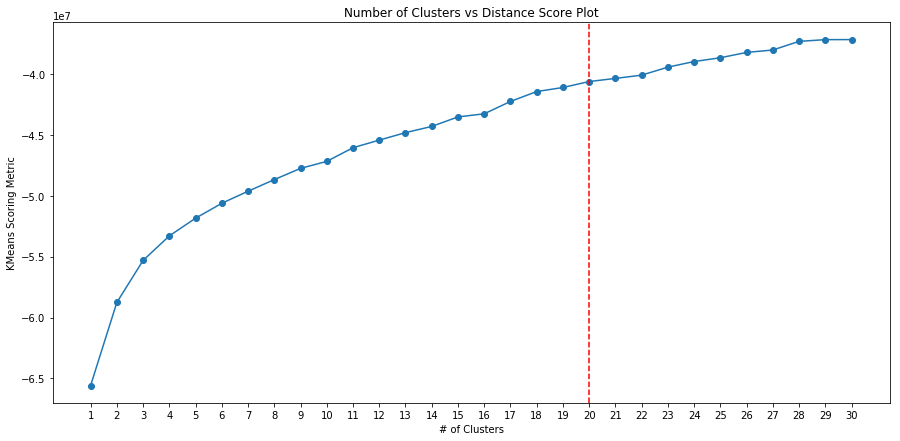

In [90]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(scores, marker='o')

#reset x-ticks and labels to represent each cluster used
ax.set_xticks(range(30))
ax.set_xticklabels(range(1, 31))

ax.axvline(x=19, linestyle='--', color='r')

#set axis labels and title
ax.set_xlabel('# of Clusters')
ax.set_ylabel('KMeans Scoring Metric')
ax.set_title('Number of Clusters vs Distance Score Plot')

plt.show()

In [91]:
#create rate of change list
score_change = []

for i, element in enumerate(scores):
    if i == 0:
        score_change.append(0)
    else:
        score_change.append(np.round((scores[i-1] - scores[i]), 2))
        
#replace the first score change in the list to the second
#this makes sure that we aren't reporting "no change", which will skew plot
score_change[0] = score_change[1]

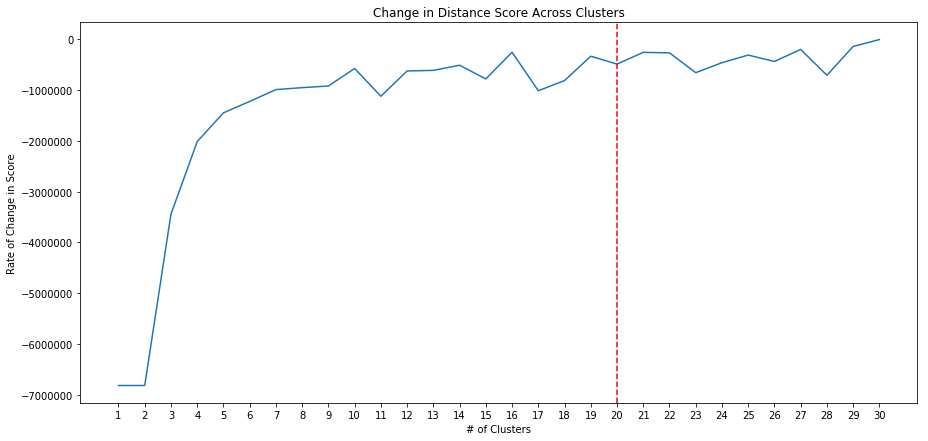

In [92]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(score_change)

#reset x-ticks and labels to represent each cluster used
ax.set_xticks(range(30))
ax.set_xticklabels(range(1, 31))

#16 clusters, changed xticks to offset of 1
ax.axvline(x=19, linestyle='--', color='r')


#set axis labels and title
ax.set_xlabel('# of Clusters')
ax.set_ylabel('Rate of Change in Score')
ax.set_title('Change in Distance Score Across Clusters')

plt.show()

In [93]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters)

preds_demo = kmeans.fit_predict(pcs)

#save cluster centers and cluster labels
cluster_centers_demo = kmeans.cluster_centers_
cluster_labels_demo = kmeans.labels_

We can see based on the KMeans score plot and the rate of score change plot that after about cluster 20, the gains for each additional cluster we add drops off. While there is still marginal improvement up to cluster 30, we can dramatically speed up our clustering by using only 20. Here, it is a balance between increasing our score and increasing our performance.

### Now we can do the same thing for the customer data

In [96]:
#total number of values possible in each column
total = customers.shape[0]

#now let's look at how many missing values there are per column
#as a percentage of the total dataset
missing_per_column2 = customers.isnull().sum() / total * 100.0

#and pring out the columns
print(sum(missing_per_column2 > 30))

8


So there aren't that many more columns in the customer subset than in the demographic subset that are missing significant portions of their data.

In [97]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
#clean the data
customers_sub = clean_data(customers)

In [98]:
print(customers_sub.shape)

(115643, 87)


In [99]:
#now ensure that the data have the same columns for scaler object
set_demo = set(azdias_sub.columns)
set_custom = set(customers_sub.columns)
set_diff = set_demo - set_custom

for column in set_diff:
    customers_sub[column] = 0

#scale the cleaned data
customers_scaled = pd.DataFrame(scaler.transform(customers_sub), columns=customers_sub.columns, index=customers_sub.index)

#pca
pca_customers = pca.transform(customers_scaled)

In [102]:
print(customers_sub.shape)

(115643, 88)


In [103]:
#cluster the data
preds_custom = kmeans.predict(pca_customers)

#save cluster centers and cluster labels
cluster_labels_custom = kmeans.labels_

### Compare customer data to demographics data

In [116]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
demographic = []
customer = []

len_demo = len(azdias)
len_cust = len(customers)

for cluster in range(num_clusters):
    demographic.append(np.sum(preds_demo==cluster)/len_demo)
    customer.append(np.sum(preds_custom==cluster)/len_cust)

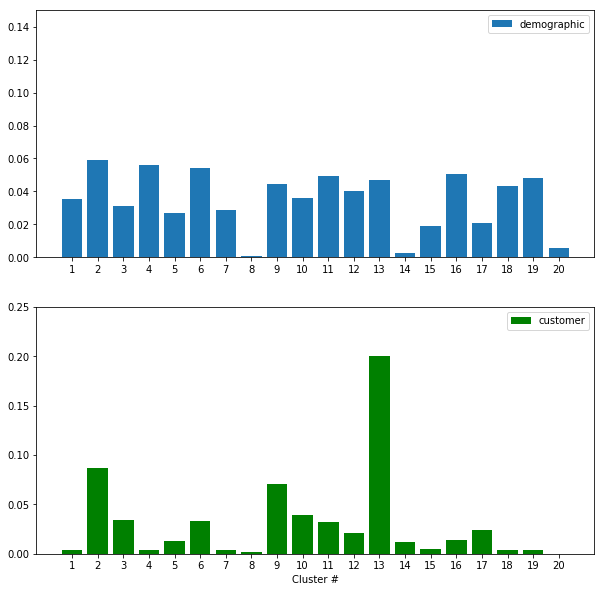

In [119]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

xticks = range(0, 20)

ax[0].bar(xticks, height=demographic, label='demographic')
ax[1].bar(xticks, height=customer, label='customer', color='g')

#reset xtick marks and labels
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(range(1, 21))
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(range(1, 21))

#to match subplot 2's y limits
ax[0].set_ylim([0,0.15])
ax[1].set_ylim([0,0.25])

ax[1].set_xlabel('Cluster #')
ax[0].legend()
ax[1].legend()

plt.show()

In [136]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
#clusters 2, 9, and 13 stand out in the customer data
#let's look at number 13
cluster_centers = kmeans.cluster_centers_

#inverse transform the data
data = scaler.inverse_transform(pca.inverse_transform(cluster_centers))

#create data frame for inspection
df = pd.DataFrame(data, index=range(num_clusters), columns=customers_sub.columns)

In [148]:
#subset for the 13th row
df13 = df.iloc[13].round()

In [149]:
print(df13[df13 != 0])

ALTERSKATEGORIE_GROB               3.0
ANREDE_KZ                          1.0
FINANZ_MINIMALIST                  4.0
FINANZ_SPARER                      2.0
FINANZ_VORSORGER                   4.0
FINANZ_ANLEGER                     2.0
FINANZ_UNAUFFAELLIGER              2.0
FINANZ_HAUSBAUER                   3.0
GREEN_AVANTGARDE                   1.0
HEALTH_TYP                         2.0
RETOURTYP_BK_S                     4.0
SEMIO_SOZ                          4.0
SEMIO_FAM                          4.0
SEMIO_REL                          3.0
SEMIO_MAT                          4.0
SEMIO_VERT                         5.0
SEMIO_LUST                         5.0
SEMIO_ERL                          5.0
SEMIO_KULT                         4.0
SEMIO_RAT                          3.0
SEMIO_KRIT                         4.0
SEMIO_DOM                          5.0
SEMIO_KAEM                         4.0
SEMIO_PFLICHT                      4.0
SEMIO_TRADV                        3.0
VERS_TYP                 

In [150]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
#clusters 1, 4, 7, 16, 18, and 19 stand out in the demographic data
#let's do the same thing for number 16
df16 = df.iloc[15].round()
print(df16[df16 != 0])

ALTERSKATEGORIE_GROB               3.0
ANREDE_KZ                          1.0
FINANZ_MINIMALIST                  3.0
FINANZ_SPARER                      3.0
FINANZ_VORSORGER                   4.0
FINANZ_ANLEGER                     2.0
FINANZ_UNAUFFAELLIGER              2.0
FINANZ_HAUSBAUER                   3.0
HEALTH_TYP                         3.0
RETOURTYP_BK_S                     4.0
SEMIO_SOZ                          5.0
SEMIO_FAM                          5.0
SEMIO_REL                          4.0
SEMIO_MAT                          4.0
SEMIO_VERT                         6.0
SEMIO_LUST                         4.0
SEMIO_ERL                          4.0
SEMIO_KULT                         5.0
SEMIO_RAT                          3.0
SEMIO_KRIT                         5.0
SEMIO_DOM                          4.0
SEMIO_KAEM                         3.0
SEMIO_PFLICHT                      4.0
SEMIO_TRADV                        3.0
VERS_TYP                           2.0
ANZ_PERSONEN             

### What groups are under/overrepresented in the customer data as compared to the demographic data?

- Overrepresented in customer data:
From the columns `'PRAEGENDE_JUGENDJAHRE_decade'`, `'CAMEO_INTL_2015_tens'`, `'FINANZ_MINIMALIST'`, `'FINANZ_SPARER.'`, and `'ANZ_TITEL'` we can see that this group of people are older, live in comfortable households, and are money-savers but have low financial-interest. So maybe they save money in a bank, but don't invest actively in high-return stocks. They also tend to live in families (or alone) with only a single person holding an academic title.

Other things that we can discern: these people are more dominant-minded, live in old West Germany, were members of an environmental sustainability program as a youth, tend to keep their purchases (show low purchase return rates), and tend to live in the same place for a while.


- Overrepresented in demographic data:
This group of people are much older, wealthier, and live in less remote regions (farther away from urban centers) than did the people from cluster 13. They also move about more than did the people in cluster 13. *This could point to the fact that people who live farther away from urban centers where there is more access to shopping would get more out of mail order shopping.*

I am basing this off of looking at the columns: `'PRAEGENDE_JUGENDJAHRE_decade'`, `'CAMEO_INTL_2015_tens'`, `'BALLRAUM'`, `'MOBI_REGIO'`, and `'FINANZ_HAUSBAUER'`.

However, while the trend is that this group of people are older and wealthier, by looking at column `'LP_LEBENSPHASE_GROB_2.0'` that this group also includes lower-income elderly folks.